# Transfer Learning

- **Definição do aprendizado de transferência**: Técnica que utiliza redes neurais previamente treinadas em grandes conjuntos de dados como base para desenvolver novos modelos precisos, mesmo com poucas amostras de treinamento.

# Extração de Featrures X Fine Tuning

- **Estratégia**:  
  - Congela as camadas iniciais/genéricas da rede e ajusta apenas as camadas posteriores.  
  - Escolha da estratégia depende do tamanho do conjunto de dados, do número de classes e da similaridade com o conjunto de dados usado para treinar a rede inicial.

# Passo a Passo do Procedimento

- **Objetivo**: Utilizar o modelo VGG16, um classificador de imagens de 1000 classes vencedor do *ImageNet Challenge 2014*, como extrator de recursos fixos para treinar um classificador personalizado em um novo conjunto de imagens.  
  - Link para o artigo sobre VGG16: [PDF](https://arxiv.org/pdf/1409.1556.pdf), [Detalhes](http://www.robots.ox.ac.uk/~vgg/research/very_deep/).  

- **Procedimento**:  
  1. Carregar o modelo VGG16 e remover sua camada final de classificação (*softmax*) de 1000 classes.  
  2. Substituir essa camada por uma nova adaptada às classes do novo conjunto de treinamento.  
  3. Congelar os pesos de todas as camadas da rede, exceto os da nova camada de classificação.  
  4. Treinar apenas a nova camada no conjunto de dados personalizado.  

- **Comparação**:  
  - Será comparado com o treinamento de uma rede neural menor do zero, mostrando que o uso do aprendizado de transferência melhora significativamente a precisão.  

- **Detalhes do conjunto de dados e resultados**:  
  - Teste realizado com 500 imagens distribuídas em 2 classes, atingindo cerca de 93% de precisão.  
  - A abordagem também funciona bem para conjuntos menores, mesmo com algumas centenas de imagens, oferecendo desempenho competitivo considerando as limitações usuais.

### Doumentação da Rede Neural Original

[Classificação de Imagens - Cats vs. Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br).


### Carregando as bibliotecas necessárias ao modelo

In [72]:
%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
# from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from google.colab import drive
from IPython.display import display
from ipywidgets import FileUpload, widgets
from PIL import Image
import requests
from io import BytesIO

import warnings
warnings.filterwarnings("ignore")

### Obtendo o Conjunto de Dados

Utilizaremos um conjunto de dados criado para este projeto, contendo 500 imagens rotuladas em 2 classes: violão (250) e guitarra (250).

Importante observar que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224.

1. Criando a montagem do Drive e configurando o caminho do dataset

In [73]:
# Montagem do drive
drive.mount('/content/drive')

# Caminho para suas imagens
root = '/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset'

train_split, val_split = 0.7, 0.15

# Categorias (subpastas no diretório root)
categories = [os.path.join(root, folder) for folder in os.listdir(root) if os.path.isdir(os.path.join(root, folder))]

print("Categorias:", categories)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Categorias: ['/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset/guitarra', '/content/drive/MyDrive/Colab Notebooks/transfer-learning-python/dataset/violao']


2. Pré-processamento dos dados das imagens e o vetor entrada.

In [74]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

3. Carregando as imagens e identificando o núemro de classes para o modelo

In [75]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)
print(f'Número de classes no dataset: ', num_classes)

Número de classes no dataset:  2


4. Definindo uma busca aleatória dos dados

In [76]:
random.shuffle(data)

5. Criando: Treinamento | Validação | Teste (70%, 15%, 15%)

In [77]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

6. Classificando os dados

Importante: o resultado apresentado do teste é alterado a cada execução da célula
```bash
random.shuffle(data)
```

In [78]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]


7. Pré-processamento dos dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [79]:
# Normalizando os data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convertendo os labels para OneHotVector
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(75, 2)


8. Resumo do projeto até o momento.

In [80]:
# Resumo
print("Carregamento de %d imagens com %d categorias"%(len(data), num_classes))
print("Treinamento | Validação | Split Teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Tamanho dos dados treinados: ", x_train.shape)
print("Tamanho dos labels: ", y_train.shape)


Carregamento de 500 imagens com 2 categorias
Treinamento | Validação | Split Teste: 350, 75, 75
Tamanho dos dados treinados:  (350, 224, 224, 3)
Tamanho dos labels:  (350, 2)


O dataset foi dividido em três subconjuntos
1. um conjunto de treinamento `train`: durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem overfitting ao conjunto de treinamento.

2. um conjunto de validação `val`: objetivo é avaliar adequadamente a precisão do nosso classificador.

3. um conjunto de teste `test`: mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

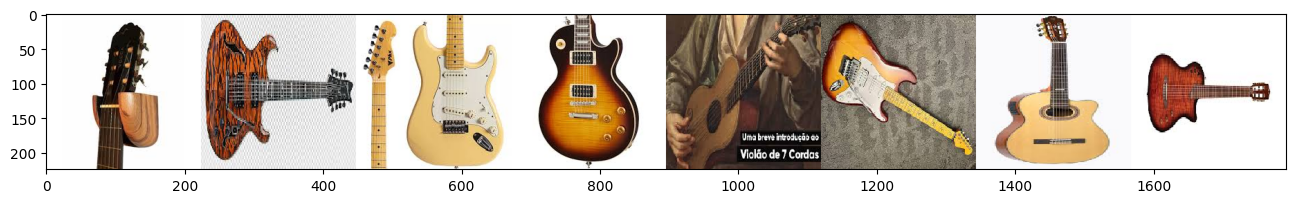

In [81]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Construção da Rede Neural Base

* **Objetivo:** Estabelecer uma linha de base para comparar com uma rede treinada posteriormente por transferência de aprendizado.
* **Estrutura:**
  * 4 pares alternados de camadas convolucionais e de pooling máximo.
  * Camadas de dropout após cada dois pares conv/pooling para regularização.
  * Uma camada totalmente conectada com 256 neurônios.
  * Outra camada de [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).
  * Camada de saída softmax para classificação.
* **Função de perda:** Entropia cruzada categórica.
* **Otimizador:** [AdaDelta](https://arxiv.org/abs/1212.5701).
* **Justificativa:** O foco é em obter uma compreensão básica e não em otimização extrema.

### Análise da Rede
* **Visualização:** A função `model.summary()` será usada para obter um resumo detalhado da arquitetura da rede neural, incluindo o número de parâmetros, formato das camadas, etc.

1. Criando uma rede neural com aproximadamente 1,2 milhões de pesos e vieses (parâmetros).

In [82]:
# Construindo a Rede Neural
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

2. Teinanando o modelo para 10 épocas com um tamanho de lote de 128.

In [83]:
# Compilando o modelo para usar a função de perda 'categorical_crossentropy' e o otimizador 'adam'
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4942 - loss: 0.7930 - val_accuracy: 0.5200 - val_loss: 0.7212
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.5159 - loss: 0.7283 - val_accuracy: 0.5467 - val_loss: 0.6905
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5788 - loss: 0.6836 - val_accuracy: 0.6800 - val_loss: 0.6829
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5473 - loss: 0.6809 - val_accuracy: 0.6667 - val_loss: 0.6727
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.5726 - loss: 0.6751 - val_accuracy: 0.6667 - val_loss: 0.6608
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6471 - loss: 0.6569 - val_accuracy: 0.6800 - val_loss: 0.6529
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.6962 - loss: 0.6333 - val_accuracy: 0.6667 - val_loss: 0.6355
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7360 - loss: 0.5967 - val_accuracy: 0.6800 - val_loss: 0

3. Avaliando a perda de validação e a precisão da validação ao longo do tempo, e comparando os resultados.

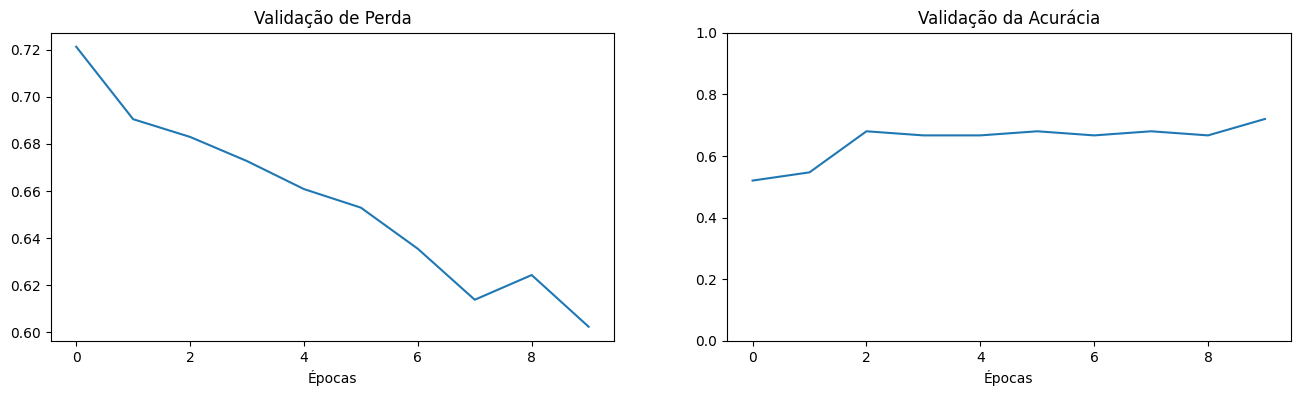

In [84]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validação de Perda")
ax.set_xlabel("Épocas")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validação da Acurácia")
ax2.set_xlabel("Épocas")
ax2.set_ylim(0, 1)

plt.show()

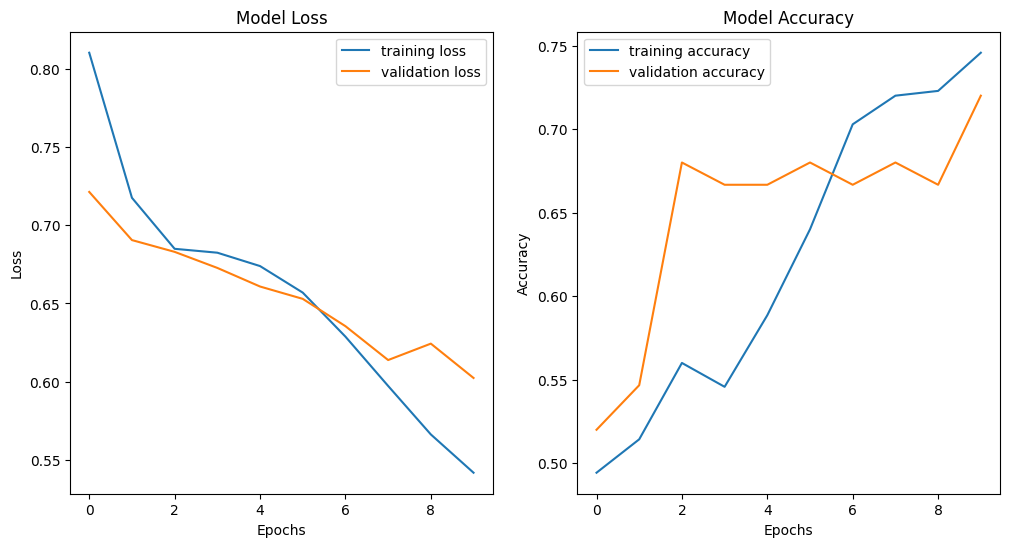

In [85]:
# Gráfico de precisão (accuracy)
fig = plt.figure(figsize=(12, 6))

# Loss (perda)
ax1 = fig.add_subplot(121)
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.set_title("Model Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Accuracy (acurácia)
ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"], label="training accuracy")
ax2.plot(history.history["val_accuracy"], label="validation accuracy")
ax2.set_title("Model Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

4. Observações e Análises pontuais ao modelo

A validação da perda no gráfico da Acurácia do Modelo começa a variar com 4 épocas, após uma crescente, acompanhando a validação da acurácia em torno de 65%. Isso sugere que nosso modelo começa a sobreajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado mais cedo por volta dessa época.

5. Avaliação Final com os seguintes resultados:

Alcançamos uma precisão de 60%, considerando o total de 500 imagens.

In [86]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Teste de Perda:', loss)
print('Teste da Acurácia:', accuracy)

Teste de Perda: 0.601443350315094
Teste da Acurácia: 0.7066666483879089


# Transfer Learning começando com a rede existente

Vamos treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

1. Carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online.

2. Depois que a rede for carregada, podemos inspecionar novamente as camadas com o método `summary()`.

In [87]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

### VGG16: Uma Rede Neural Convolucional

**Objetivo do VGG16:**
* Treinado para o conjunto de dados ImageNet com 1000 classes.
* Alcançou uma taxa de erro top-5 de 8.8%, o que significa que 91.2% das imagens foram classificadas corretamente entre as 5 principais previsões.

**Características do VGG16:**
* **Tamanho:** Muito maior que a rede construída anteriormente, com 13 camadas convolucionais e 2 camadas totalmente conectadas.
* **Parâmetros:** Mais de 138 milhões de parâmetros.
* **Complexidade:** Arquitetura profunda, com várias camadas e um grande número de parâmetros.

**Adaptação do VGG16 para Novos Conjuntos de Dados:**
* **Remoção da camada de saída:** A camada softmax original, projetada para 1000 classes do ImageNet, é substituída por uma nova camada softmax com o número de neurônios correspondente ao novo conjunto de dados.
* **Criação de um novo modelo:** Em vez de modificar diretamente o modelo VGG16, cria-se um novo modelo com a mesma arquitetura até a penúltima camada, e adiciona-se a nova camada softmax.
* **Eficiência:** O Keras copia as camadas por referência, evitando duplicação desnecessária de dados e economizando memória.

3. Utilizando a classe keras `Model` para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada `new_classification_layer`.

In [88]:
# camada de entrada do VGG
inp = vgg.input

# nova camada softmax com neurônios num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# conectando a nova camada à penúltima camada no VGG e faça uma referência a ela
out = new_classification_layer(vgg.layers[-4].output)

# criando a nova rede entre inp e out
model_new = Model(inp, out)

 ## Praticando Tranfer Learning

 Na prática, vamos ao processo de aplicação de uma rede neural pré-treinada (VGG16) para um novo conjunto de dados, utilizando a técnica de transfer learning. A ideia central é aproveitar os conhecimentos adquiridos durante o treinamento em um grande conjunto de dados para acelerar o aprendizado em um conjunto de dados menor e mais específico.

In [89]:
# Treinando  algumas camadas convolucionais para permitir ajuste fino e mantendo os pesos das demais fixas (congeladas)
for l, layer in enumerate(model_new.layers[:-4]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-4:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │          50,178 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 2,409,986 (9.19 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Olhando para o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que pelas quatro últimas camadas, anteriormente um softmax de 1000 neurônios, foi substituída por um novo softmax de 2 neurônios. Além disso, temos agora quase 14,8 milhões de pesos, com puco mais de 12 milhões de "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Temos apenas 2,4 milhões de parâmetros treináveis, em contraste com os 138 milhões do primeiro modelo, representando 1,4%.

In [90]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4831 - loss: 4.0290 - val_accuracy: 0.7733 - val_loss: 0.5070
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 777ms/step - accuracy: 0.7212 - loss: 0.6926 - val_accuracy: 0.4800 - val_loss: 0.7121
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 868ms/step - accuracy: 0.6356 - loss: 0.5844 - val_accuracy: 0.7867 - val_loss: 0.4486
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 876ms/step - accuracy: 0.8641 - loss: 0.3391 - val_accuracy: 0.7067 - val_loss: 0.4680
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 889ms/step - accuracy: 0.9360 - loss: 0.2020 - val_accuracy: 0.8933 - val_loss: 0.3010
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 779ms/step - accuracy: 0.9332 - loss: 0.1549 - val_accuracy: 0.8267 - val_loss: 0.3657
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 878ms/step - accuracy: 0.9976 - loss: 0.0592 - val_accuracy: 0.8800 - val_loss: 0.2685
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step - accuracy: 0.9956 - loss: 0.0366 - val_accuracy: 0.9067 - val_loss: 0.

Vamos plotar a validação de perda e de acurácia novamente, desta vez comparando o modelo original treinado do zero (azul) e o novo modelo aprendido por transferência (laranja-tracejado).

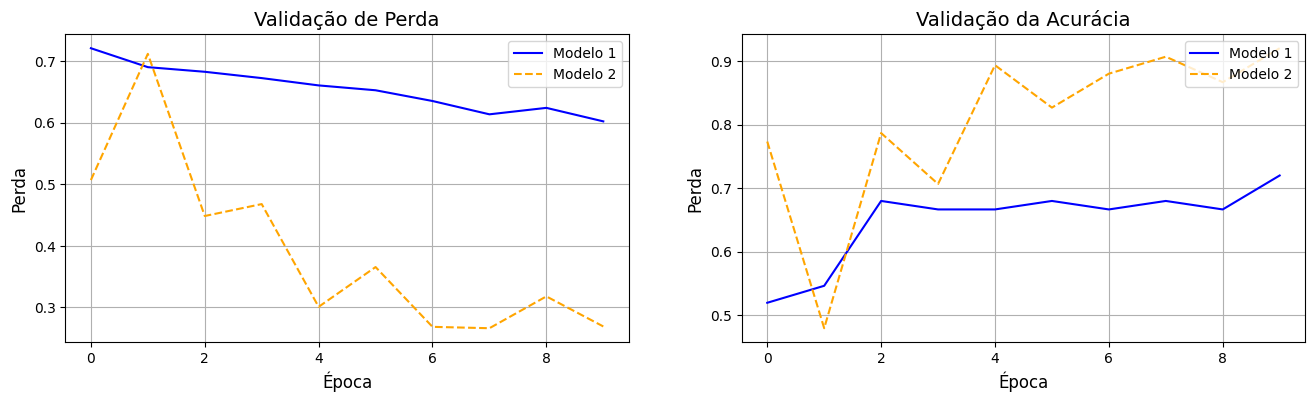

In [97]:
# Gráfico com legendas e labels
fig = plt.figure(figsize=(16, 4))

# Gráfico da Perda de Validação
ax1 = fig.add_subplot(121)
ax1.plot(history.history["val_loss"], label="Modelo 1", color="blue", linestyle="-")
ax1.plot(history2.history["val_loss"], label="Modelo 2", color="orange", linestyle="--")
ax1.set_title("Validação de Perda", fontsize=14)
ax1.set_xlabel("Época", fontsize=12)
ax1.set_ylabel("Perda", fontsize=12)
ax1.legend(loc="upper right", fontsize=10)
ax1.grid(True)

# Gráfico da Acurácia de Validação
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Modelo 1", color="blue", linestyle="-")
ax2.plot(history2.history["val_accuracy"], label="Modelo 2", color="orange", linestyle="--")
ax2.set_title("Validação da Acurácia", fontsize=14)
ax2.set_xlabel("Época", fontsize=12)
ax2.set_ylabel("Perda", fontsize=12)
ax2.legend(loc="upper right", fontsize=10)
ax2.grid(True)

Observe que, enquanto o modelo original começou a sobreajustar em torno da época 4, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado sua precisão ligeiramente com mais iterações.

Novamente, fazemos uma validação final no conjunto de teste.

In [92]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.2609451413154602
Test accuracy: 0.9200000166893005


## Consideração Finais ao Modelo

**Desempenho do modelo:**
* Com uma validação de perda de 26%, a precisão alcança os impressionantes 92% é considerada boa, considerando o número de classes e o tamanho do conjunto de dados.

**Possíveis melhorias:**
* **Aumento de dados:** Criar variações das imagens de treinamento para aumentar o tamanho do conjunto e melhorar a generalização do modelo.
* **Hiperparâmetros:** Experimentar diferentes otimizadores, taxas de aprendizado, regularização e outras configurações.
* **Treinamento mais longo:** Permitir que o modelo aprenda padrões mais complexos.

**Referência:**
* **[Blog do Keras](https://blog.keras.io/):** Apresenta um exemplo mais avançado de *transfer learning* com aumento de dados para um conjunto de dados menor.

**Conclusão:**
O modelo apresentou um bom desempenho, mas há potencial para melhorias através de técnicas como aumento de dados e ajuste de hiperparâmetros.


## Agora é sua vez de se divertir e aplicar o modelo!

A seguir, você pode carregar uma imagem válida, de violão ou guitarra, e aplicar o presente modelo de classificação com redes neurais.

Boa diversão!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


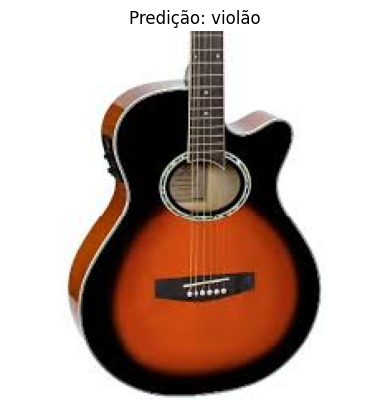

Probabilidade: [[0. 1.]]
Classe predita: violão
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


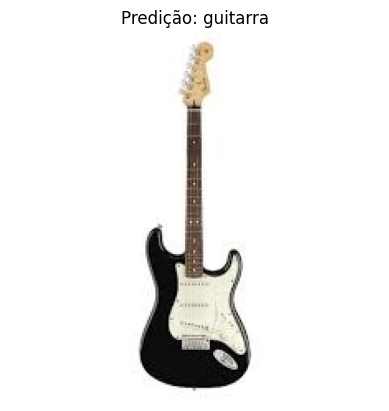

Probabilidade: [[1. 0.]]
Classe predita: guitarra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


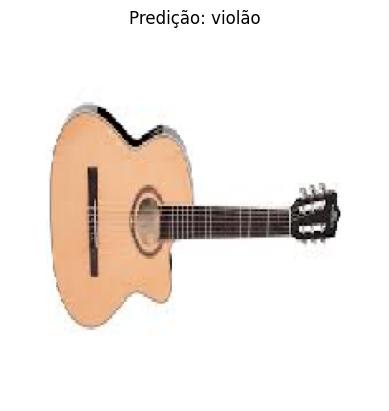

Probabilidade: [[0. 1.]]
Classe predita: violão


In [94]:
def classify_image_external(model, image_path, class_labels):
    """
    Classifica uma imagem utilizando o modelo treinado.

    Args:
        model: O modelo treinado para a classificação.
        image_path: Caminho ou objeto da imagem a ser classificada.
        class_labels: Lista com os nomes das classes (ex: ['violao', 'guitarra']).

    Returns:
        None. Exibe a imagem e a classe prevista.
    """
    # Carregar e preprocessar a imagem
    img, x = get_image(image_path)
    probabilities = model.predict([x])

    # Determinar a classe com maior probabilidade
    predicted_class = class_labels[np.argmax(probabilities)]

    # Exibir a imagem e o resultado da classificação
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predição: {predicted_class}")
    plt.show()

    print(f"Probabilidade: {probabilities}")
    print(f"Classe predita: {predicted_class}")

# Lista de classes do modelo
class_labels = ["guitarra", "violão"]

# Função para processar imagem local
def upload_image(change):
    uploaded_file = next(iter(upload_widget.value.values()))
    content = uploaded_file['content']

    # Salvar a imagem para processamento
    with open("temp_image.jpg", "wb") as f:
        f.write(content)
    classify_image_external(model_new, "temp_image.jpg", class_labels)

# Função para processar imagem de URL
def classify_image_from_url(url):
    try:
        # Requisição HTTP para a URL
        response = requests.get(url)

        # Verificação se o conteúdo retornado é válido
        if response.status_code == 200 and "image" in response.headers["Content-Type"]:
            # Abrindo a imagem diretamente
            img = Image.open(BytesIO(response.content))
            img.save("temp_url_image.jpg")  # Salvar a imagem temporariamente
            classify_image_external(model_new, "temp_url_image.jpg", class_labels)
        else:
            print("Erro: O link fornecido não retorna uma imagem válida.")
    except Exception as e:
        print(f"Erro ao carregar a imagem da URL: {e}")

# Widgets para interação
upload_widget = FileUpload(accept='image/*', multiple=False)
url_widget = widgets.Text(
    value='',
    placeholder='Digite a URL da imagem',
    description='URL:',
    layout=widgets.Layout(width='50%')
)
button_url = widgets.Button(description="Classificar Imagem URL")
output = widgets.Output()

def on_button_url_click(b):
    with output:
        output.clear_output()
        classify_image_from_url(url_widget.value)

# Conectando os widgets às funções
upload_widget.observe(upload_image, names='value')
button_url.on_click(on_button_url_click)

# Exibir os widgets
display(widgets.VBox([
    widgets.HTML("<h3>Selecione uma Imagem:</h3>"),
    upload_widget,
    widgets.HTML("<h3>Ou forneça uma URL:</h3>"),
    url_widget,
    button_url,
    output
]))
